In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, BLUE_COLOR, get_net_currents, cross_correlation, min_max_scale
from nanonets.utils import create_weighted_undirected_graph, display_net_flow_graph
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate2d, correlate
from scipy.optimize import curve_fit

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"

In [3]:
AMPLITUDE_LIST  = [0.02,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9

topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()

### Internal Dynamics

In [5]:
e_type      = 'constant'
dts         = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps     = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time        = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data        = {amp : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
states      = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
currents    = {amp : {freq : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6 for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

In [6]:
amp      = 0.02
t_points = [0,int(0.25*SAMPLE_P_PERIOD),int(0.5*SAMPLE_P_PERIOD),int(0.75*SAMPLE_P_PERIOD)]
phi_vecs = {}
q_vecs   = {}
t_vecs   = {}
x_vecs   = {}
y_vecs   = {}

for freq in FREQ_LIST_MHZ:

    t       = time[freq][:-1][:-N_SKIP*SAMPLE_P_PERIOD]*1e9
    x       = data[amp][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:]*1000
    y       = data[amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:]*1e-6
    phi_vec = states[amp][freq].iloc[N_SKIP*SAMPLE_P_PERIOD:,N_ELECTRODES:].values
    q_vec   = (CAP_MAT @ phi_vec.T).T/E_CHARGE

    phi_vecs[freq]  = phi_vec.copy()
    q_vecs[freq]    = q_vec.copy()
    t_vecs[freq]    = t.copy()
    x_vecs[freq]    = x.copy()
    y_vecs[freq]    = y.copy()

### Spatial Correlation

In [7]:
def get_2D_correlation(arr):
    
    def exp_decay(x, length):
        return np.exp(-x / length)

    arr = arr - np.mean(arr)
    a_c = correlate2d(arr, arr, mode='same', boundary='wrap')
    a_c = a_c / np.max(a_c)

    center_y = a_c.shape[0] // 2
    profile  = a_c[center_y, :]
    lags     = np.arange(profile.size) - (profile.size // 2)

    positive_lags    = lags[lags >= 0]
    decaying_profile = profile[lags >= 0]
    params, _   = curve_fit(exp_decay, positive_lags, decaying_profile)
    corr_length = params[0]

    return a_c, corr_length

N_samples   = 20
q_c_max     = []
q_c_zero    = []
phi_c_max   = []
phi_c_zero  = []

for freq in FREQ_LIST_MHZ:
    vals = [get_2D_correlation(q_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(9,9)) for i in range(N_samples)]
    q_c_max.append(vals)

    vals = [get_2D_correlation(q_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(9,9)) for i in range(N_samples)]
    q_c_zero.append(vals)

    vals = [get_2D_correlation(phi_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(9,9)) for i in range(N_samples)]
    phi_c_max.append(vals)

    vals = [get_2D_correlation(phi_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(9,9)) for i in range(N_samples)]
    phi_c_zero.append(vals)

phi_c_m_max     = np.mean(np.array([[q_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))]),axis=1)
phi_c_l_max     = np.array([[q_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
phi_c_m_zero    = np.mean(np.array([[q_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))]),axis=1)
phi_c_l_zero    = np.array([[q_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

np.save(f"data/phi_c_m_max_{amp:.3f}.npy", phi_c_m_max)
np.save(f"data/phi_c_l_max_{amp:.3f}.npy", phi_c_l_max)
np.save(f"data/phi_c_m_zero_{amp:.3f}.npy", phi_c_m_zero)
np.save(f"data/phi_c_l_zero_{amp:.3f}.npy", phi_c_l_zero)

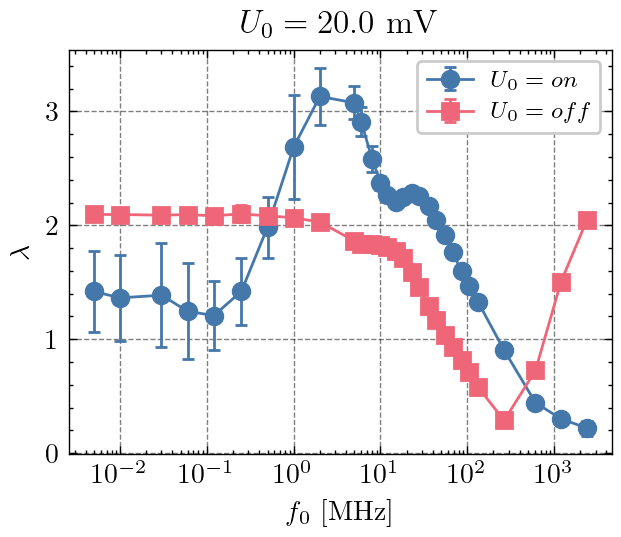

In [8]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.errorbar(FREQ_LIST_MHZ, np.mean(phi_c_l_max,axis=1), 1.95*np.std(phi_c_l_max,axis=1), marker='o', capsize=2, label='$U_0 = on$')
ax.errorbar(FREQ_LIST_MHZ, np.mean(phi_c_l_zero,axis=1), 1.95*np.std(phi_c_l_zero,axis=1), marker='s', capsize=2, label='$U_0 = off$')
ax.set_xscale('log')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$\lambda$")
ax.legend(fontsize='small')
ax.set_title(f"$U_0 = {amp*1000}$ mV")
fig.savefig(f"plots/svg/lambda_vs_f0_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/lambda_vs_f0_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/lambda_vs_f0_{amp:.3f}.png", transparent=False)

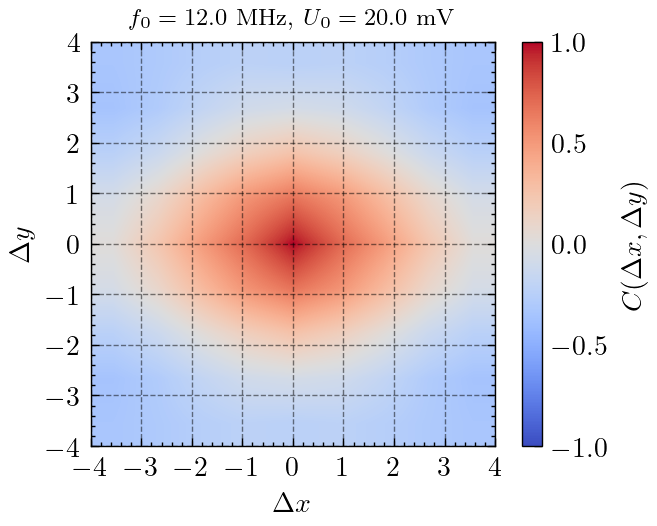

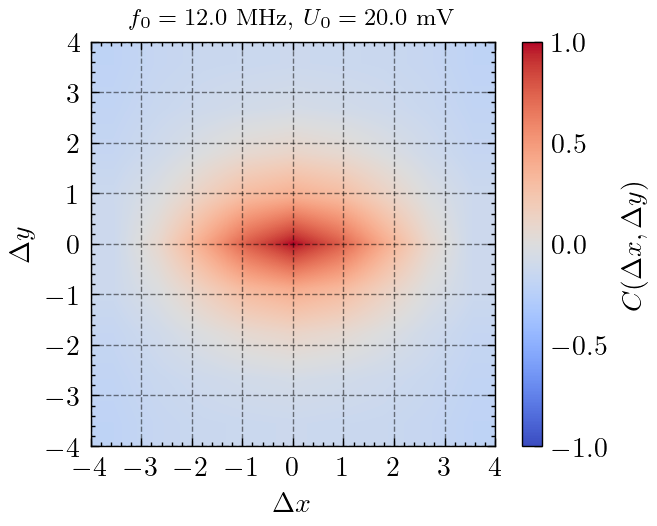

In [11]:
freq = 12.0
idx  = np.argwhere(np.array(FREQ_LIST_MHZ)==freq)[0][0]
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(phi_c_m_max[idx], cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear', extent=[-4, 4, -4, 4])
_   = ax.set_xticks(np.arange(-4,5))
_   = ax.set_yticks(np.arange(-4,5))
_   = fig.colorbar(im, ax=ax, label='$C(\Delta x,\Delta y)$', orientation='vertical')
ax.set_xlabel("$\Delta x$")
ax.set_ylabel("$\Delta y$")
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
fig.savefig(f"plots/svg/c_maps/ac_map_at_max_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/c_maps/ac_map_at_max_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/c_maps/ac_map_at_max_{freq:.3f}_{amp:.3f}.png", transparent=False)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(phi_c_m_zero[idx], cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear', extent=[-4, 4, -4, 4])
_   = ax.set_xticks(np.arange(-4,5))
_   = ax.set_yticks(np.arange(-4,5))
_   = fig.colorbar(im, ax=ax, label='$C(\Delta x,\Delta y)$', orientation='vertical')
ax.set_xlabel("$\Delta x$")
ax.set_ylabel("$\Delta y$")
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
fig.savefig(f"plots/svg/c_maps/ac_map_at_zero_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/c_maps/ac_map_at_zero_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/c_maps/ac_map_at_zero_{freq:.3f}_{amp:.3f}.png", transparent=False)

### Time Constants

In [20]:
taus = np.zeros(shape=(len(FREQ_LIST_MHZ),int(N_NP*N_NP)))

for j, freq in enumerate(FREQ_LIST_MHZ):
    x_vals  = x_vecs[freq].copy()
    for n in range(N_NP*N_NP):
        y_vals      = q_vecs[freq][:,n]
        c_vals      = correlate(y_vals, x_vals, mode='same')
        midpoint    = len(c_vals) // 2
        i_val       = np.argmax(np.abs(c_vals)) - midpoint
        dt          = time[freq][1] - time[freq][0]
        t_val       = i_val * dts[freq]
        T           = 1 / (freq * 1e6)
        t_val_phys  = t_val % T
        # if t_val < 0:
        #     t_val = t_val + T
        taus[j,n] = t_val_phys / T
taus_df = pd.DataFrame([taus[i,:] for i in range(len(FREQ_LIST_MHZ))], index=FREQ_LIST_MHZ).T.melt(var_name='freq',value_name='tau')
taus_df.to_csv(f"data/taus_df_{amp:.3f}.csv")

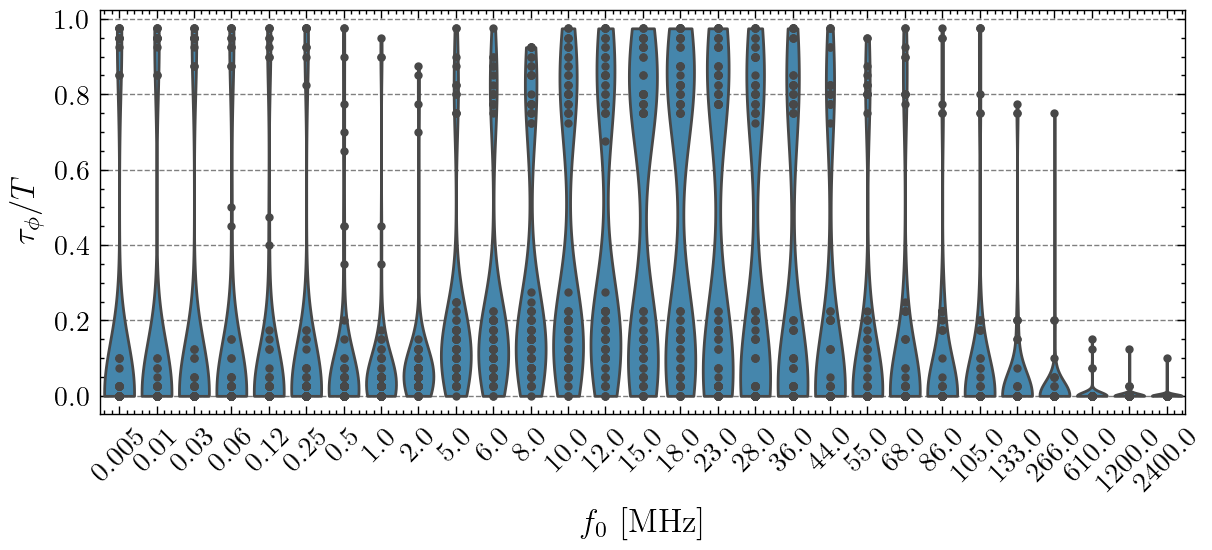

In [21]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()
ax  = sns.violinplot(data=taus_df, x='freq', y='tau', cut=0, ax=ax, scale='width', color=BLUE_COLOR, inner='point')
_   = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_   = ax.set_ylabel("$\\tau_\phi / T$", fontsize='large')
_   = plt.xticks(rotation=45)
fig.savefig(f"plots/svg/tau_vs_freq_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/tau_vs_freq_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/tau_vs_freq_{amp:.3f}.png", transparent=False)

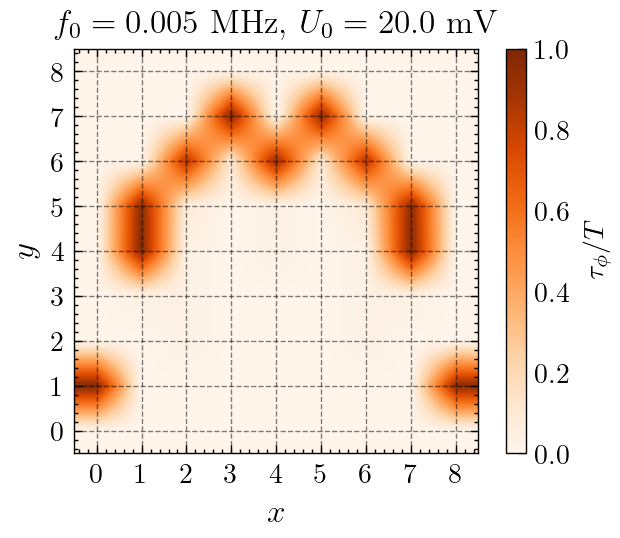

In [26]:
freq = 0.005
idx  = np.argwhere(np.array(FREQ_LIST_MHZ)==freq)[0][0]
arr  = taus[idx,:].reshape(N_NP,N_NP)
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(arr, cmap='Oranges', vmin=0, vmax=1, interpolation='bilinear')
_   = ax.set_xticks(np.arange(N_NP))
_   = ax.set_yticks(np.arange(N_NP))
_   = fig.colorbar(im, ax=ax, label='$\\tau_\phi / T$', orientation='vertical')
ax.invert_yaxis()
ax.set_xlabel("$x$", fontsize='large')
ax.set_ylabel("$y$", fontsize='large')
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV")
fig.savefig(f"plots/svg/tau_dist_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/tau_dist_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/tau_dist_{freq:.3f}_{amp:.3f}.png", transparent=False)

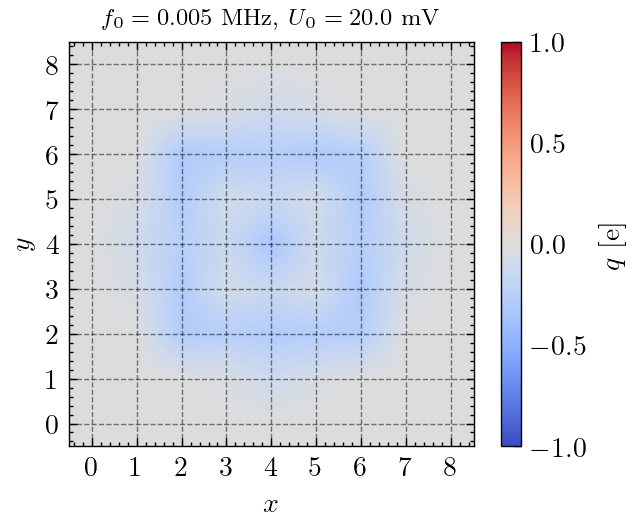

In [34]:
freq    = 0.005
arr     = np.mean([q_vecs[freq][i*SAMPLE_P_PERIOD,:] for i in range(N_samples)],axis=0).reshape(9,9)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(arr, cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear')
_   = ax.set_xlabel("$x$")
_   = ax.set_ylabel("$y$")
_   = ax.set_xticks(np.arange(9))
_   = ax.set_yticks(np.arange(9))
ax.invert_yaxis()
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
fig.colorbar(im, ax=ax, label='$q$ [e]', orientation='vertical')
fig.savefig(f"plots/svg/internal/max_charge_landscape_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/max_charge_landscape_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/max_charge_landscape_{freq:.3f}_{amp:.3f}.png", transparent=False)

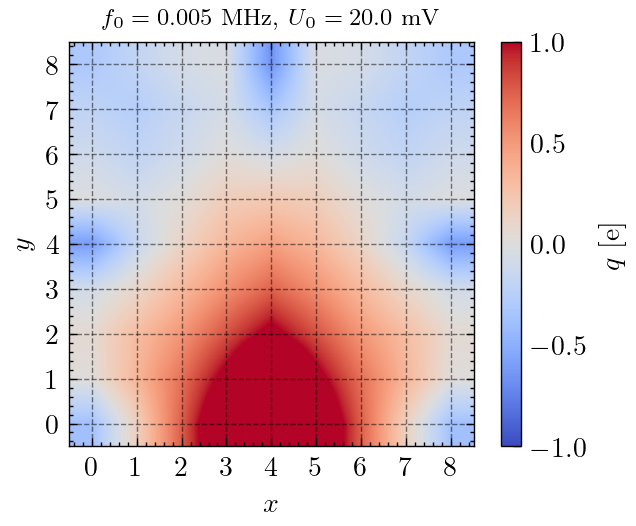

In [37]:
freq    = 0.005
arr     = np.mean([q_vecs[freq][i*SAMPLE_P_PERIOD+int(0.25*SAMPLE_P_PERIOD),:] for i in range(N_samples)],axis=0).reshape(9,9)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(arr, cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear')
_   = ax.set_xlabel("$x$")
_   = ax.set_ylabel("$y$")
_   = ax.set_xticks(np.arange(9))
_   = ax.set_yticks(np.arange(9))
ax.invert_yaxis()
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
fig.colorbar(im, ax=ax, label='$q$ [e]', orientation='vertical')
fig.savefig(f"plots/svg/internal/center_charge_landscape_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/center_charge_landscape_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/center_charge_landscape_{freq:.3f}_{amp:.3f}.png", transparent=False)

In [412]:
# freq    = 133.0
# arr     = np.mean([phi_vecs[freq][i*SAMPLE_P_PERIOD,:] for i in range(N_samples)],axis=0).reshape(9,9)

# fig = plt.figure(dpi=200)
# ax  = fig.add_subplot()
# im  = ax.imshow(1000*arr, cmap='coolwarm', vmin=-15, vmax=15, interpolation='bilinear')
# _   = ax.set_xlabel("$x$")
# _   = ax.set_ylabel("$y$")
# _   = ax.set_xticks(np.arange(9))
# _   = ax.set_yticks(np.arange(9))
# ax.invert_yaxis()
# fig.colorbar(im, ax=ax, label='$\phi(x,y)$ [mV]', orientation='vertical')
# fig.savefig(f"plots/svg/internal/max_pot_landscape_{freq:.3f}_{amp:.3f}.svg", transparent=True)
# fig.savefig(f"plots/pdf/internal/max_pot_landscape_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
# fig.savefig(f"plots/png/internal/max_pot_landscape_{freq:.3f}_{amp:.3f}.png", transparent=False)

In [411]:
# freq    = 133.0
# arr     = np.mean([phi_vecs[freq][i*SAMPLE_P_PERIOD+int(0.25*SAMPLE_P_PERIOD),:] for i in range(N_samples)],axis=0).reshape(9,9)

# fig = plt.figure(dpi=200)
# ax  = fig.add_subplot()
# im  = ax.imshow(1000*arr, cmap='coolwarm', vmin=-15, vmax=15, interpolation='bilinear')
# _   = ax.set_xlabel("$x$")
# _   = ax.set_ylabel("$y$")
# _   = ax.set_xticks(np.arange(9))
# _   = ax.set_yticks(np.arange(9))
# ax.invert_yaxis()
# fig.colorbar(im, ax=ax, label='$\phi(x,y)$ [mV]', orientation='vertical')
# fig.savefig(f"plots/svg/internal/zero_pot_landscape_{freq:.3f}_{amp:.3f}.svg", transparent=True)
# fig.savefig(f"plots/pdf/internal/zero_pot_landscape_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
# fig.savefig(f"plots/png/internal/zero_pot_landscape_{freq:.3f}_{amp:.3f}.png", transparent=False)

In [40]:
rms_gs      = {}
rms_flow    = {}
for amp in AMPLITUDE_LIST:
    rms_gs2     = []
    rms_flow2   = []
    for freq in FREQ_LIST_MHZ:
        df_net  = get_net_currents(currents[amp][freq].copy())
        G       = create_weighted_undirected_graph(np.sqrt((df_net**2).sum()))
        rms_gs2.append(G)
        rms_flow2.append(nx.maximum_flow_value(G, _s=0, _t=7, capacity='weight'))
    rms_gs[amp]   = rms_gs2
    rms_flow[amp] = rms_flow2

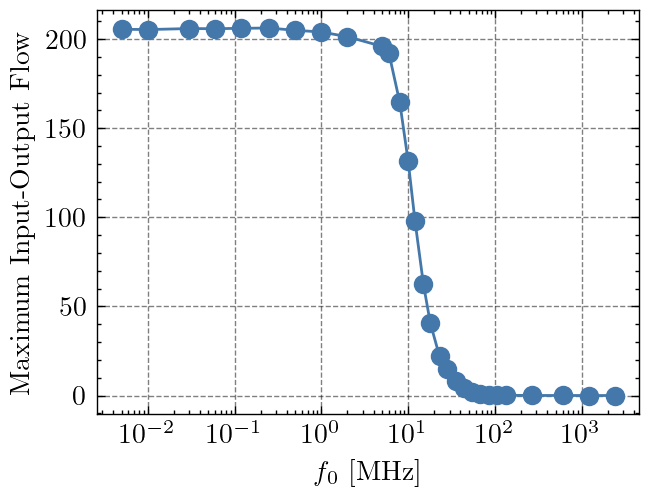

In [41]:
amp     = 0.02
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, rms_flow[amp], '-o')
ax.set_xscale("log")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("Maximum Input-Output Flow")
fig.savefig(f"plots/svg/internal/max_flow_input_output_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/max_flow_input_output_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/max_flow_input_output_{amp:.3f}.png", transparent=False)

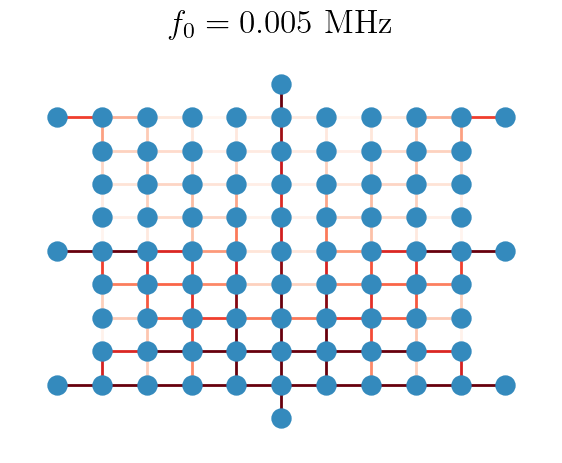

In [58]:
amp  = 0.02
freq = 0.005
# freq = 23.0
idx  = np.argwhere(np.array(FREQ_LIST_MHZ)==freq)[0][0]
fig, ax = plt.subplots(dpi=200)
ax = display_net_flow_graph(rms_gs[amp][idx], pos=pos, log_sacle=False, font_size=None, ax=ax, vmin=0, vmax=200)
_  = ax.set_title(f"$f_0 = {freq}$ MHz")
fig.savefig(f"plots/svg/internal/net_flow_rms_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/net_flow_rms_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/net_flow_rms_{freq:.3f}_{amp:.3f}.png", transparent=False)

---

### Animation

In [ ]:
# def animate_potential_landscape(potential_data_list, t_vector: np.ndarray,
#                                 title_prefix: str = "Potential Landscape",
#                                 output_filename: str = "potential_animation.mp4"):
#     """
#     Creates and saves an animation of the 9x9 potential landscape over time.

#     Args:
#         potential_data_list (List[np.ndarray]): A list of 2D numpy arrays, where each
#                                              array has shape (9, 9) and represents
#                                              the node potentials at a single time step.
#         t_vector (np.ndarray): 1D numpy array of time values corresponding to the frames.
#         title_prefix (str): A string to prepend to the animation title (e.g., "Active Regime").
#         output_filename (str): The filename to save the animation (e.g., 'animation.mp4' or 'animation.gif').
#                                Requires a writer like ffmpeg or imagemagick.
#     """
    
#     with plt.style.context(["science","bright","grid"]):

#         # --- Convert list of 2D arrays to a single 3D numpy array for easier handling ---
#         try:
#             potential_data_TXY = np.array(potential_data_list)
#         except Exception as e:
#             raise TypeError(f"Could not convert the input list to a NumPy array. Please ensure it's a list of 2D arrays. Error: {e}")

#         # Basic validation
#         if potential_data_TXY.ndim != 3 or potential_data_TXY.shape[1:] != (N_NP, N_NP):
#             raise ValueError("Input data must resolve to a 3D array of shape (num_timesteps, 9, 9).")

#         num_timesteps = potential_data_TXY.shape[0]

#         # --- Setup the plot ---
#         fig, ax = plt.subplots(layout='tight')

#         # Determine a fixed color scale based on the global min/max of the entire dataset.
#         # This is CRITICAL to prevent the color bar from flickering.
#         vmin = -np.max(np.abs(potential_data_TXY))
#         vmax = np.max(np.abs(potential_data_TXY))

#         # Display the first frame (t=0)
#         # We use origin='lower' to match your coordinate system (y=0 at the bottom).
#         im = ax.imshow(potential_data_TXY[0, :, :], vmin=vmin, vmax=vmax,
#                         cmap='coolwarm', origin='lower', interpolation='bicubic')

#         ax.set_xlabel("$x$")
#         ax.set_ylabel("$y$")
#         ax.set_xticks(np.arange(N_NP))
#         ax.set_yticks(np.arange(N_NP))

#         cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#         cbar.set_label("$\phi$ [mV]")

#         time_text = ax.set_title("")

#         # --- Animation update function ---
#         def update(frame_index):
#             data_slice = potential_data_TXY[frame_index, :, :]
#             im.set_array(data_slice)
#             current_time = t_vector[frame_index]
#             time_text.set_text(f'Time: {1000*current_time:.1f} ms')
#             return [im, time_text]

#         # --- Create and save the animation ---
#         print("Creating animation... This may take a few moments.")

#         if len(t_vector) > 1:
#             dt = (t_vector[1] - t_vector[0]) * 1000  # interval in ms
#         else:
#             dt = 50  # default to 20 fps

#         ani = FuncAnimation(fig, update, frames=num_timesteps,
#                             interval=dt, blit=True, repeat=True)

#         try:
#             ani.save(output_filename, writer='ffmpeg', fps=15, dpi=150)
#             print(f"Animation successfully saved to '{output_filename}'")
#         except Exception as e:
#             print(f"Error saving animation: {e}")
#             print("Please ensure you have a writer like 'ffmpeg' installed and accessible in your system's PATH.")
            
#         plt.close(fig)

In [ ]:
# freq    = 18.0
# amp     = 0.02
# n_p     = 8
# f_name  = f"pot_landscape_{freq}_{amp}.gif"
# y       = states[amp][freq].iloc[:SAMPLE_P_PERIOD*n_p,N_ELECTRODES:].values*1000

# y_t = [np.array(y_t).reshape(9,9) for y_t in y.tolist()]
# t   = time[freq][:SAMPLE_P_PERIOD*n_p]*1e6

# animate_potential_landscape(y_t, t, output_filename=f_name)

MovieWriter ffmpeg unavailable; using Pillow instead.


Creating animation... This may take a few moments.
Animation successfully saved to 'pot_landscape_18.0_0.02.gif'
